### 1. Identifying phase transitions using t-SNE 

a) using dimensional reducetion to identify phases of matter doesn't require the lables to perform the classification. We can see that in this problem we just have spin configuration and use lables for only coloring the result which is different from Problem 2 of Homework 1 which it require the lables for classification task.

b) the code below is the implementation of t-SNE method which can run by executing the function `tsne` which have arguments (`X`, `no_dims`, `initial_dims`, `perplexity`): 
- `X` is the input data contain NxD, number of configuations x dimensions of each configuration.
- `no_dims` is the number of dimension (typically 2 or 3 for visualization).
- `initial_dims` is the number of dimension that apply data to pca before go to tsne in order to reduce noise.
- `perplexity` (from Laurens van der Maaten webpage) is a measure for information defined as 2 to the power of the Shannon entropy. Typical values for the perplexity range between 5 and 50. In t-SNE may be viewed as the variables that control the number of effective nearest neighbors. Loosly speaking , a larger / denser dataset requires a larger perplexity.

In [82]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = max(sum(P),1e-13)#sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 500
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [85]:
#For Download data (stored on Mohamed's github account)
#!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/PCA_tutorial_data/Tutorial_Data.zip
#!unzip -j Tutorial_Data.zip

c) Applies t-SNE to the data set

### Identify phase transition of the two-dimensional classical Ising model

In [127]:
#Import library and load dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
spin_L20     = np.loadtxt( 'spinConfigs_Ising_L20.txt', dtype='int16' )
spin_L40     = np.loadtxt( 'spinConfigs_Ising_L40.txt', dtype='int16' )
spin_L80     = np.loadtxt( 'spinConfigs_Ising_L80.txt', dtype='int16' )
tem_L20     = np.loadtxt( 'temperatures_Ising_L20.txt', dtype='float32' )
tem_L40     = np.loadtxt( 'temperatures_Ising_L40.txt', dtype='float32' )
tem_L80     = np.loadtxt( 'temperatures_Ising_L80.txt', dtype='float32' )

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.667250
Iteration 100: error is 16.664719
Iteration 200: error is 1.651261
Iteration 300: error is 1.495078
Iteration 400: error is 1.433213
Iteration 500: error is 1.401004


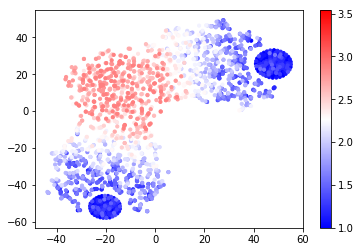

In [99]:
#L = 20
X = spin_L20
labels = tem_L20
Y = tsne(X, 2, 20, 20.0);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

In [ ]:
#For L = 20, using perplexity = 20.0, we get a good classification.

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.382330
Iteration 100: error is 19.618413
Iteration 200: error is 1.955866
Iteration 300: error is 1.704480
Iteration 400: error is 1.598067
Iteration 500: error is 1.539935


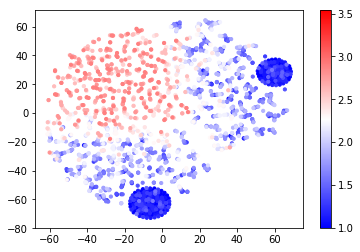

In [140]:
X = spin_L20
labels = tem_L20
Y = tsne(X, 2, 40, 30);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.170250
Iteration 100: error is 21.321203
Iteration 200: error is 2.216597
Iteration 300: error is 1.965274
Iteration 400: error is 1.862971
Iteration 500: error is 1.806466


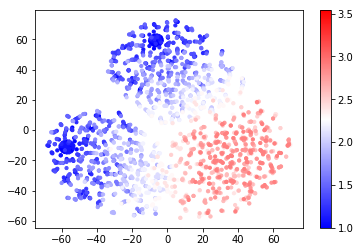

In [91]:
#L = 40 #Mickey mouse structure
X = spin_L40
labels = tem_L40
Y = tsne(X, 2, 40, 4.0);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 3.067459
Iteration 100: error is 15.848435
Iteration 200: error is 1.828805
Iteration 300: error is 1.719464
Iteration 400: error is 1.680803
Iteration 500: error is 1.661056


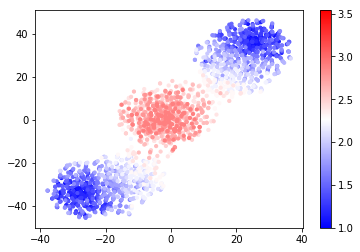

In [141]:
#L = 40 
X = spin_L40
labels = tem_L40
Y = tsne(X, 2, 50, 30);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

In [ ]:
#For L = 40, using perplexity = 4.0, we get a good classification.

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 5.127264
Iteration 100: error is 15.119959
Iteration 200: error is 1.828274
Iteration 300: error is 1.770444
Iteration 400: error is 1.750449
Iteration 500: error is 1.740792


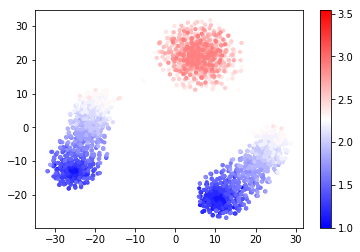

In [142]:
#L = 80
X = spin_L80
labels = tem_L80
Y = tsne(X, 2, 80, 30);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 3.324631
Iteration 100: error is 17.965686
Iteration 200: error is 1.930813
Iteration 300: error is 1.738051
Iteration 400: error is 1.666804
Iteration 500: error is 1.630591


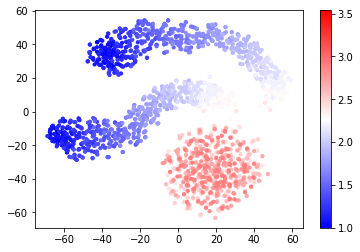

In [110]:
X = spin_L80
labels = tem_L80
Y = tsne(X, 2, 40, 30);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.668404
Iteration 100: error is 14.721938
Iteration 200: error is 1.640252
Iteration 300: error is 1.573645
Iteration 400: error is 1.550201
Iteration 500: error is 1.538271


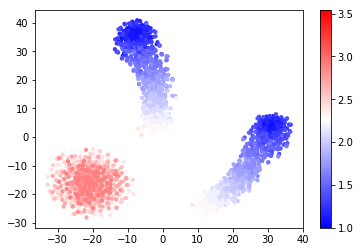

In [143]:
X = spin_L80
labels = tem_L80
Y = tsne(X, 2, 40, 30.0);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels, cmap='bwr', vmin=1, vmax=2/np.log(1+np.sqrt(2))*2-1)
plt.colorbar()

In [ ]:
#For L = 40, using perplexity = 4.0, we get a good classification.

d)  
 - How do the clustering results from t-SNE change as L increase?
 It is hard to say about the difference of clutersing results among L = 20,40 and 80 because it also sentitive to perplexity and initial_dim. As far as I know from the result, they are clearly separated as L is higher (L=80)
 - Show that if you apply the t-SNE code twice to the same dataset, you get different results. Why do suh differences occur?
We can see that from the last two previous figure in case of L = 80. Although using the same dataset and same parameter, the final result is not the same. This is because the cost function of t-SNE is a non-convex function. When performing the gradient descent, it is possible to get stuck at the local minima.
- Compare your results for the Ising model with Figure 6 of Reference[3].
We can see that it seperate to 3 clusters which similar to Figure 6.
- Compare your results with the result of Tutorial 5
The main different is that the result in Tutorial 5 is better as increasing L.

### Ising gauge theory

e) Repeat part c) for Ising gauge theory for L = 20 and 40

In [117]:
#Import library and load dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
Gauge_L20     = np.loadtxt( 'spinConfigs_gaugeTheory_L20.txt', dtype='int16' )
Gauge_L40     = np.loadtxt( 'spinConfigs_gaugeTheory_L40.txt', dtype='int16' )
#Gauge_L80     = np.loadtxt( 'spinConfigs_gaugeTheory_L80.txt', dtype='int16' )
labels_L20     = np.loadtxt( 'labels_gaugeTheory_L20.txt', dtype='float32' )
labels_L40     = np.loadtxt( 'labels_gaugeTheory_L40.txt', dtype='float32' )
#labels_L80     = np.loadtxt( 'labels_gaugeTheory_L80.txt', dtype='float32' )

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 3.657033
Iteration 100: error is 17.285478
Iteration 200: error is 2.402739
Iteration 300: error is 2.371385
Iteration 400: error is 2.356231
Iteration 500: error is 2.351055


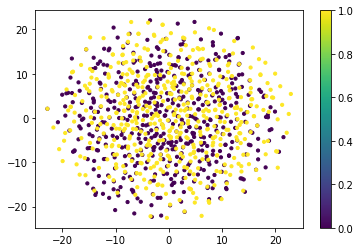

In [125]:
#L=20
X = Gauge_L20
labels = labels_L20
Y = tsne(X, 2, 40, 50);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels)
plt.colorbar()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 6.120161
Iteration 100: error is 14.268864
Iteration 200: error is 1.930495
Iteration 300: error is 1.857960
Iteration 400: error is 1.856520
Iteration 500: error is 1.856331


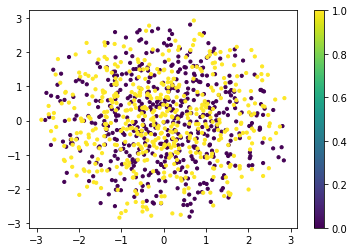

In [139]:
#L=40
X = Gauge_L40
labels = labels_L40
Y = tsne(X, 2, 40, 30);
pylab.scatter(Y[:, 0], Y[:, 1], 10, labels)
plt.colorbar()

We can see that the results are random which means t-SNE fails for this data set.

f) The reason why t-SNE fails to produce cluster is that there is no the simialrity of between data of any two different topologically-ordered configuration (when we use Euclidean distance to determine the similarity, maybe somehow if we can have some function that can determine similarity how about comparison of product spin of each configuration?. Anyway, t-SNE is also not appropiate with this data structure). Unlike 2-D Ising model which the ferromagnetic phase likely to be order (mostly up or mostly down) then they can form the cluster.

*** 
<center> The Notebook end here </center>  

***